# Chapter 5 - Connections between Causality and Deep Learning

The notebook is a code companion to chapter 5 of the book [Causal Machine Learning](https://www.manning.com/books/causal-machine-learning) by Robert Osazuwa Ness.

In [ ]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 722 kB 5.0 MB/s 


Here, we demonstrate using a variational autoencoder to fit the following causal DAG.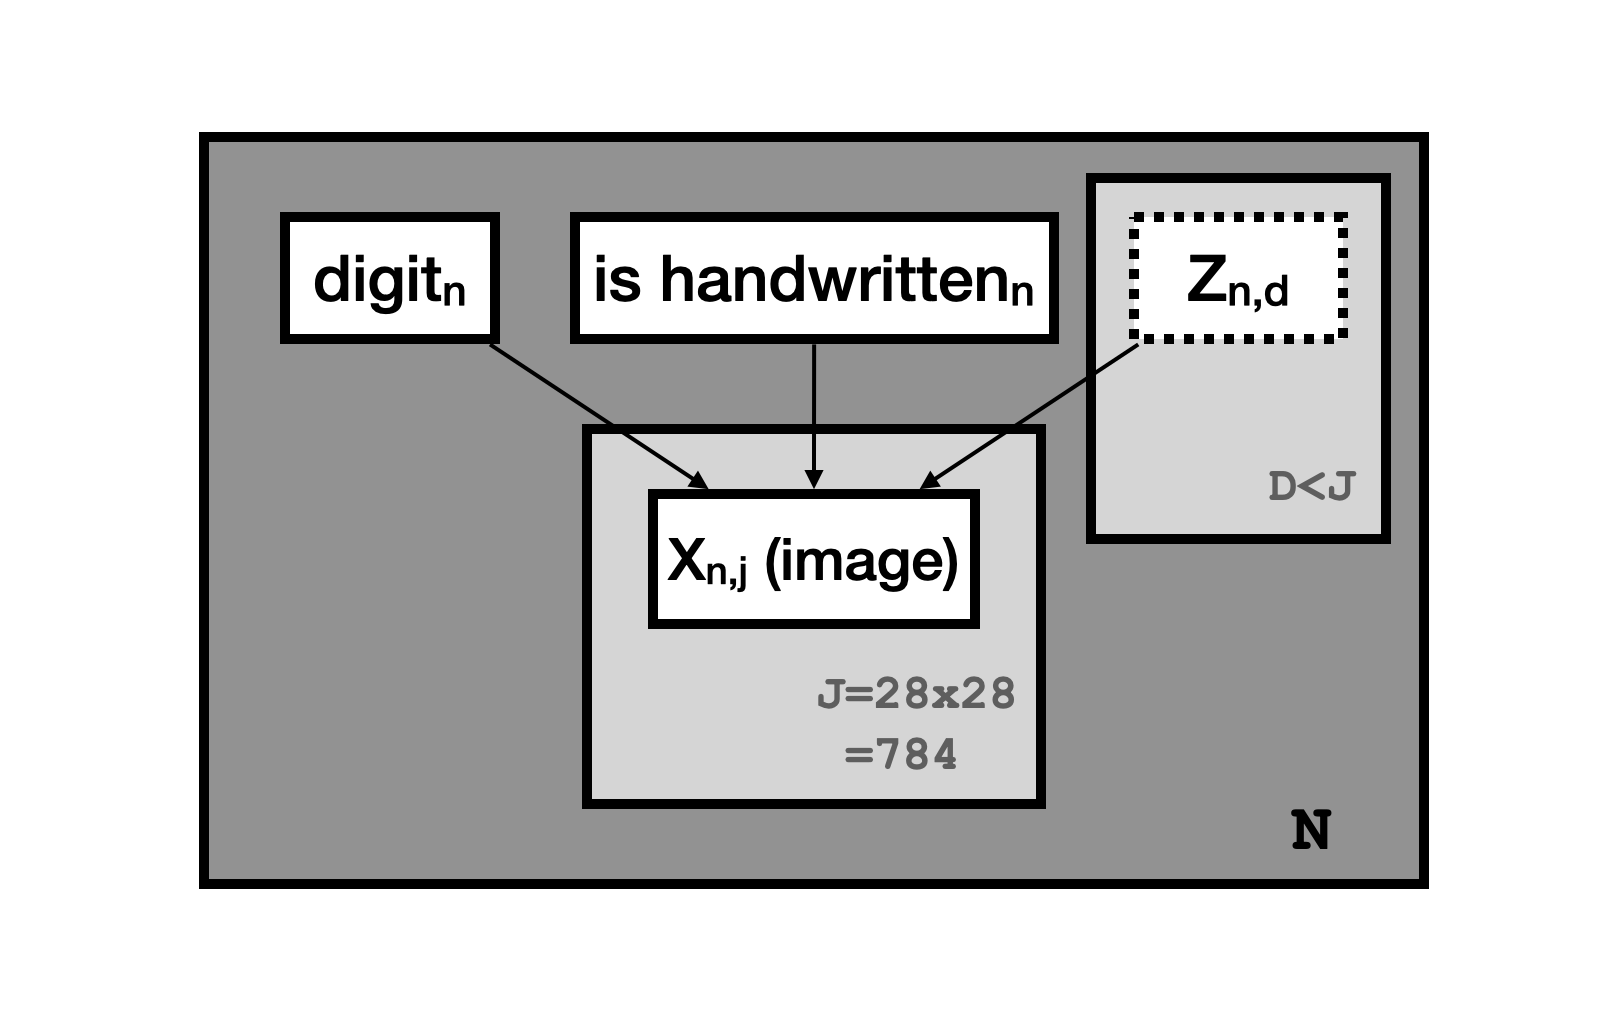

Digit is the digit label of the image.  The dataset combines MNIST data with [Typeface MNIST](https://www.kaggle.com/datasets/7a2a5621ee8c66c1aba046f9810a79aa27aafdbbe5d6a475b861d2ba8552d1fc).  Typeface MNIST has 2990 font labels, but here we define a simple new label "is handwritten" which is 1 if an image is a handwritten MNIST data and 0 if it is a typed TypefaceMNIST image.

In [ ]:
import random

import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from torchvision.transforms import ToTensor, Lambda

import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#assert pyro.__version__.startswith('1.8.1')
pyro.distributions.enable_validation(False)

In [ ]:
class CombinedDataset(Dataset):
    '''
    Create a dataset combining the MNIST and Typeface MNIST data.
    Input: Path to the data
    Output: torch.utils.data.Dataset
    '''

    def __init__(self, csv_file):
        self.data_frame = pd.read_csv(csv_file) # read the csv file

    def __len__(self):
        return len(self.data_frame) # return the length of the dataset

    def __getitem__(self, idx):
        # Load, normalize, and reshape the digits to 28x28 
        images = self.data_frame.iloc[idx, 3:]
        images = np.array([images])/255.
        images = images.reshape(28, 28)
        images = images.astype('float32')
        transform = transforms.ToTensor()
        images = transform(images)

        # Get and process the digits
        digits = self.data_frame.iloc[idx, 2]
        digits = np.array([digits])
        digits = digits.astype('int')
        digits = int(digits.squeeze())

        # is_handwritten is 1 for MNIST and 0 for TMNIST
        is_handwritten = self.data_frame.iloc[idx , 1]
        is_handwritten = np.array(is_handwritten)
        is_handwritten = is_handwritten.astype('int')
        
        return images, digits, is_handwritten


In [ ]:
# for loading and batching TMNIST-MNIST dataset
def setup_data_loaders(batch_size=64, use_cuda=False): 

    combined_dataset = CombinedDataset(
        "https://raw.githubusercontent.com/altdeep/causalML/master/datasets/combined_mnist_tmnist_data.csv"
    )
    n = len(combined_dataset) # number of samples in the dataset

    # Split the dataset into train and test
    train_length = int(n*0.7) 
    test_length = n - train_length
    train_set, test_set = torch.utils.data.random_split(
        dataset=combined_dataset,
        lengths=[train_length, test_length],
        generator=torch.Generator().manual_seed(43)
    )

    # Create data loaders for train and test
    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        shuffle=True,
        **kwargs
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_set,
        batch_size=batch_size,
        shuffle=False,
        **kwargs
    )
    return train_loader, test_loader


In [ ]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim + 10 + 2, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z, digit, is_handwritten):
        # define the forward computation on the latent z
        # first compute the hidden units
        input = torch.cat([z, digit, is_handwritten], 1)
        hidden = self.softplus(self.fc1(input))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        X_img_parameter = self.sigmoid(self.fc21(hidden))
        return X_img_parameter

In [ ]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the three linear transformations used
        x_dim = 784
        digit_dim = 10
        self.fc1 = nn.Linear(x_dim + digit_dim + 2, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x, digit, is_handwritten):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        input = torch.cat([x, digit, is_handwritten], 1)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(input))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [ ]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x, digit, is_handwritten):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        batch_size = x.size(0)
        options = dict(dtype=x.dtype, device=x.device)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            digit_prob = torch.ones(batch_size, 10, **options) / 10.0
            digit = pyro.sample("digit", dist.OneHotCategorical(digit_prob), obs=digit)

            hw_prob = torch.ones(batch_size, 2, **options) / 2.0
            is_handwritten = pyro.sample("is_handwritten", dist.OneHotCategorical(hw_prob), obs=is_handwritten)
            
            # decode the latent code z and the digit
            X_img_param = self.decoder.forward(z, digit, is_handwritten)
            # score against actual images
            X_img = pyro.sample("obs", dist.Bernoulli(X_img_param).to_event(1), obs=x.reshape(-1, 784))
        return X_img

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x, digit, is_handwritten):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x, digit, is_handwritten)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x, digit, is_handwritten):
        # encode image x
        z_loc, z_scale = self.encoder(x, digit, is_handwritten)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z, digit, is_handwritten)
        return loc_img
    

In [ ]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False

# Run only for a single iteration for testing
NUM_EPOCHS = 100
TEST_FREQUENCY = 5

In [ ]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, digit, is_handwritten in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # Convert digit to one-hot-encoding
        digit = torch.nn.functional.one_hot(digit, 10)
        is_handwritten = torch.nn.functional.one_hot(is_handwritten, 2)
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x, digit, is_handwritten)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, digit, is_handwritten in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # Convert digit to one-hot encoding
        digit = torch.nn.functional.one_hot(digit, 10)
        is_handwritten = torch.nn.functional.one_hot(is_handwritten, 2)
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x, digit, is_handwritten)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [ ]:
def plot_regenerate(x, digit, is_handwritten):
    fig = plt.figure
    plt.imshow(x.view(28, 28).cpu().data.numpy(), cmap='gray')
    plt.show()
    x_generated = vae.reconstruct_img(x, digit, is_handwritten)
    plt.imshow(x_generated.view(28, 28).cpu().data.numpy(), cmap='gray')
    plt.show()

[epoch 000] average training loss: 203.8253
[epoch 000] average test loss: 170.4374


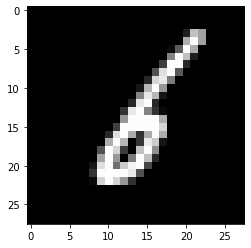

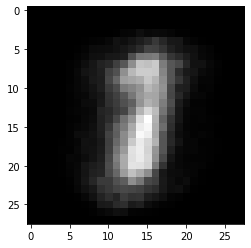

------------------------------


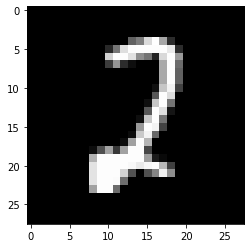

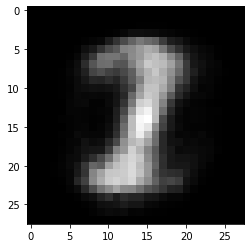

------------------------------


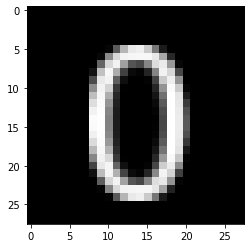

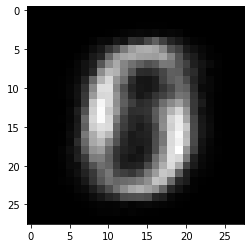

------------------------------
[epoch 001] average training loss: 155.8688
[epoch 002] average training loss: 140.4656
[epoch 003] average training loss: 132.2010
[epoch 004] average training loss: 126.4545
[epoch 005] average training loss: 122.3957
[epoch 005] average test loss: 121.2622


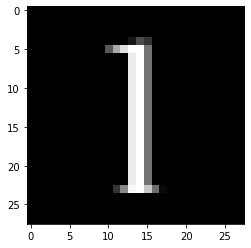

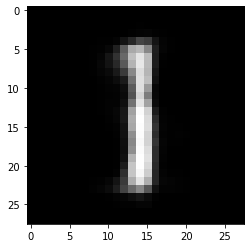

------------------------------


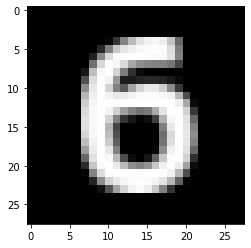

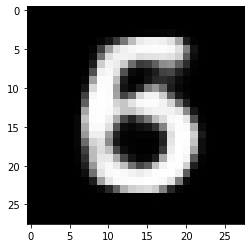

------------------------------


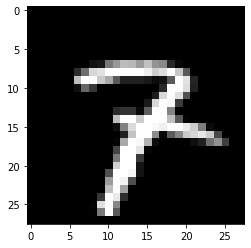

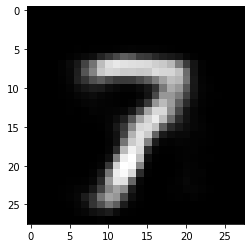

------------------------------
[epoch 006] average training loss: 119.4387
[epoch 007] average training loss: 117.2279
[epoch 008] average training loss: 115.4205
[epoch 009] average training loss: 113.8984
[epoch 010] average training loss: 112.6800
[epoch 010] average test loss: 112.8203


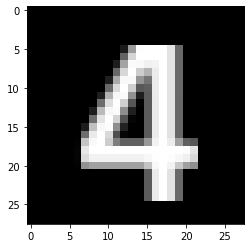

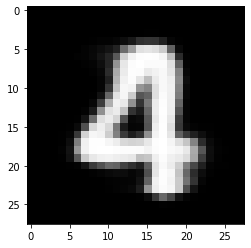

------------------------------


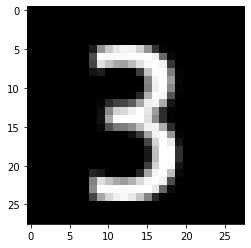

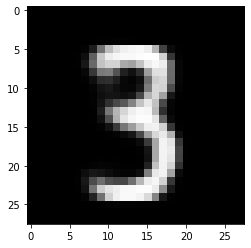

------------------------------


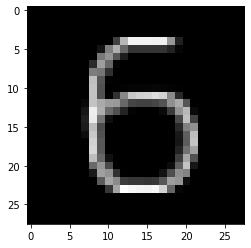

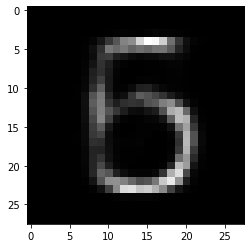

------------------------------
[epoch 011] average training loss: 111.6498
[epoch 012] average training loss: 110.7951
[epoch 013] average training loss: 110.0567
[epoch 014] average training loss: 109.3805
[epoch 015] average training loss: 108.7260
[epoch 015] average test loss: 109.1462


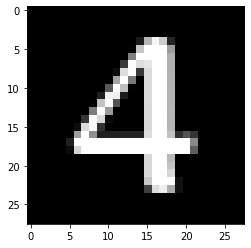

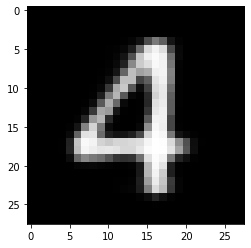

------------------------------


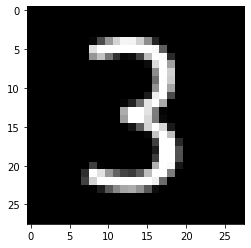

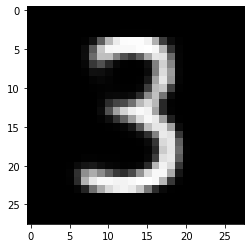

------------------------------


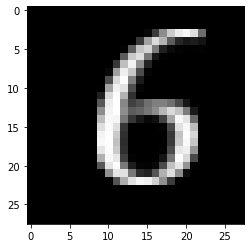

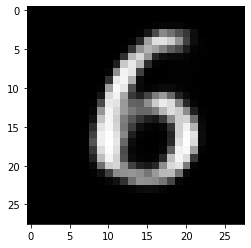

------------------------------
[epoch 016] average training loss: 108.2924
[epoch 017] average training loss: 107.7512
[epoch 018] average training loss: 107.3286
[epoch 019] average training loss: 106.9651
[epoch 020] average training loss: 106.6272
[epoch 020] average test loss: 107.2013


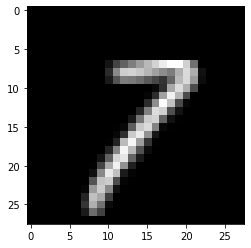

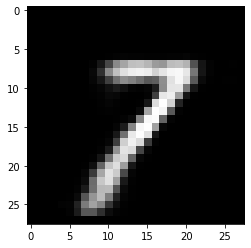

------------------------------


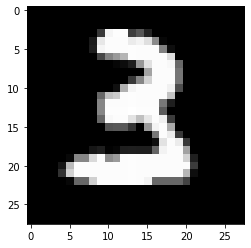

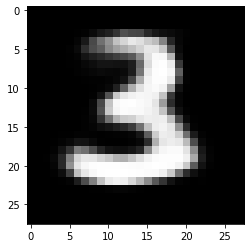

------------------------------


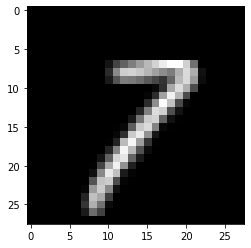

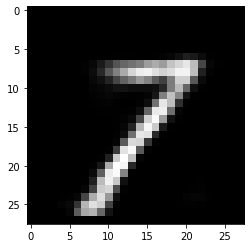

------------------------------
[epoch 021] average training loss: 106.2911
[epoch 022] average training loss: 105.8809
[epoch 023] average training loss: 105.5553
[epoch 024] average training loss: 105.3544
[epoch 025] average training loss: 105.0808
[epoch 025] average test loss: 105.9499


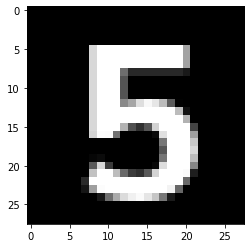

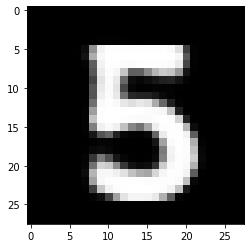

------------------------------


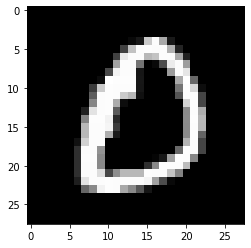

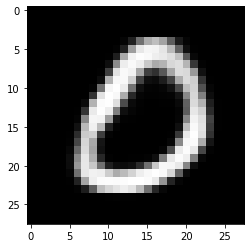

------------------------------


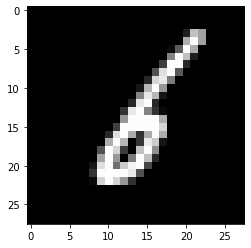

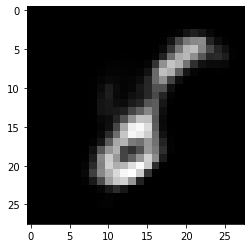

------------------------------
[epoch 026] average training loss: 104.8435
[epoch 027] average training loss: 104.6011
[epoch 028] average training loss: 104.4001
[epoch 029] average training loss: 104.2091
[epoch 030] average training loss: 103.9728
[epoch 030] average test loss: 105.2448


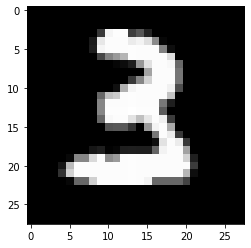

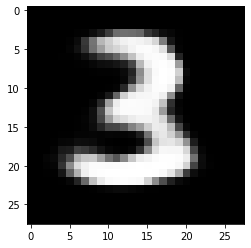

------------------------------


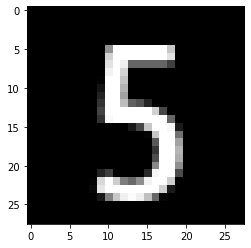

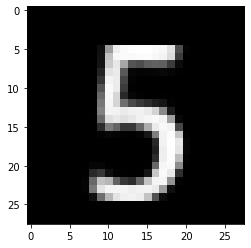

------------------------------


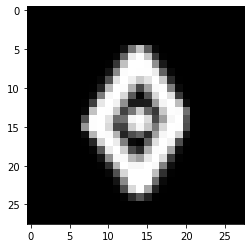

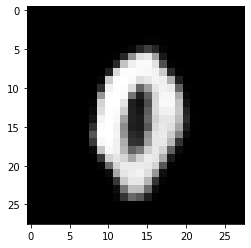

------------------------------
[epoch 031] average training loss: 103.8193
[epoch 032] average training loss: 103.6066
[epoch 033] average training loss: 103.4449
[epoch 034] average training loss: 103.3161
[epoch 035] average training loss: 103.1212
[epoch 035] average test loss: 104.1819


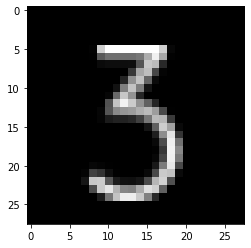

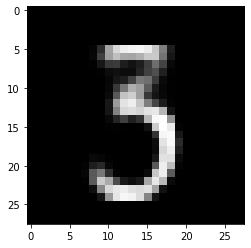

------------------------------


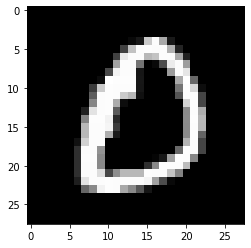

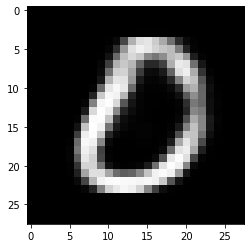

------------------------------


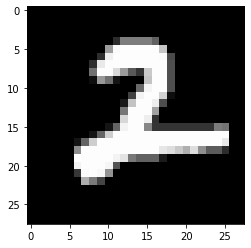

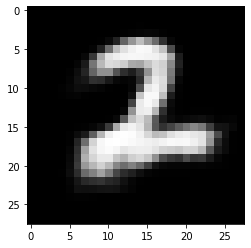

------------------------------
[epoch 036] average training loss: 103.0091
[epoch 037] average training loss: 102.8443
[epoch 038] average training loss: 102.7880
[epoch 039] average training loss: 102.5584
[epoch 040] average training loss: 102.4623
[epoch 040] average test loss: 103.7718


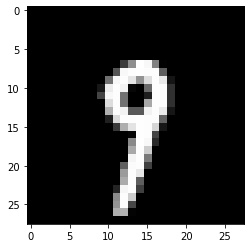

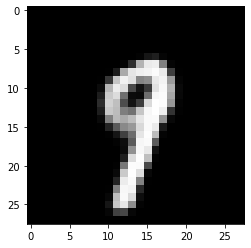

------------------------------


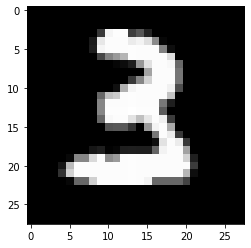

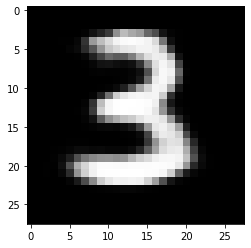

------------------------------


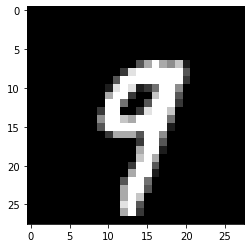

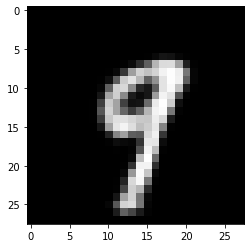

------------------------------
[epoch 041] average training loss: 102.3434
[epoch 042] average training loss: 102.2857
[epoch 043] average training loss: 102.1521
[epoch 044] average training loss: 102.0641
[epoch 045] average training loss: 101.9485
[epoch 045] average test loss: 103.1888


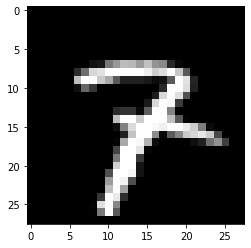

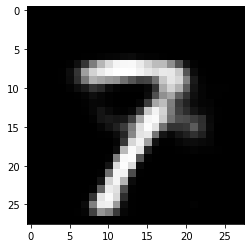

------------------------------


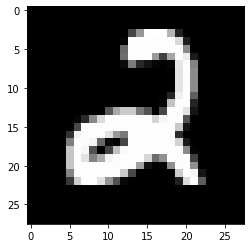

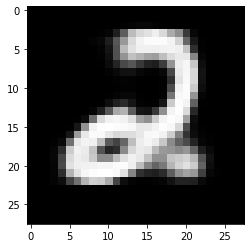

------------------------------


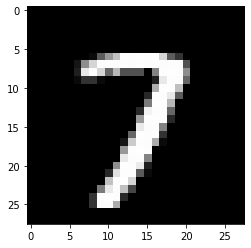

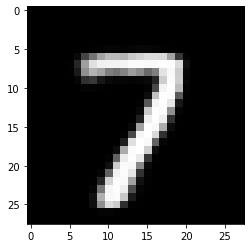

------------------------------
[epoch 046] average training loss: 101.8604
[epoch 047] average training loss: 101.7486
[epoch 048] average training loss: 101.6591
[epoch 049] average training loss: 101.5569
[epoch 050] average training loss: 101.4555
[epoch 050] average test loss: 102.9081


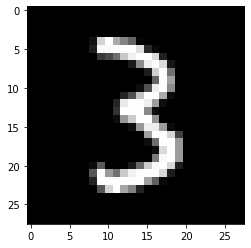

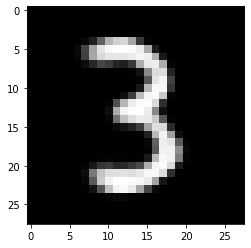

------------------------------


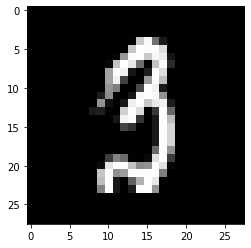

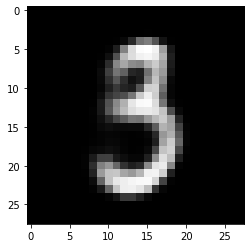

------------------------------


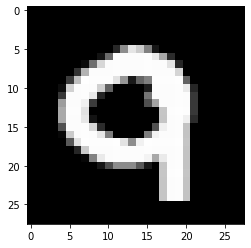

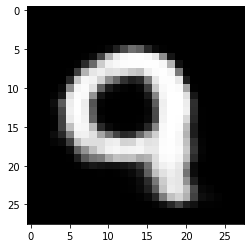

------------------------------
[epoch 051] average training loss: 101.3678
[epoch 052] average training loss: 101.3266
[epoch 053] average training loss: 101.1838
[epoch 054] average training loss: 101.1840
[epoch 055] average training loss: 101.0747
[epoch 055] average test loss: 102.4332


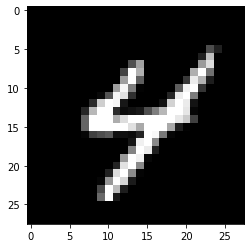

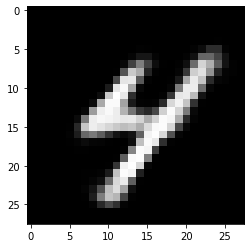

------------------------------


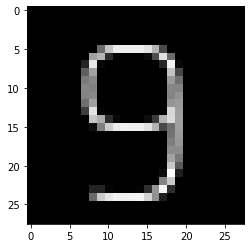

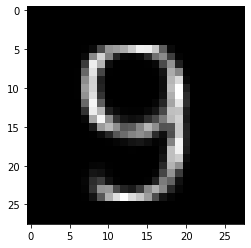

------------------------------


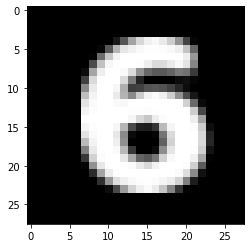

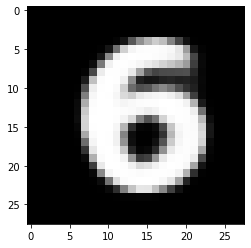

------------------------------
[epoch 056] average training loss: 101.0162
[epoch 057] average training loss: 100.9381
[epoch 058] average training loss: 100.8788
[epoch 059] average training loss: 100.8215
[epoch 060] average training loss: 100.7433
[epoch 060] average test loss: 102.1327


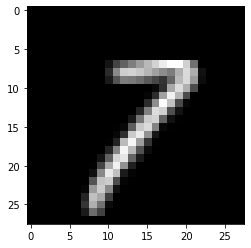

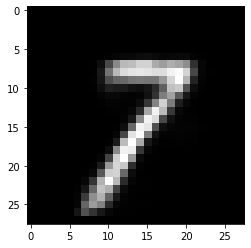

------------------------------


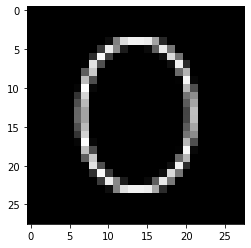

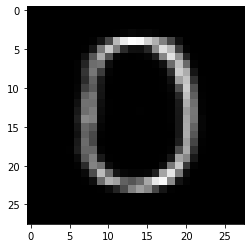

------------------------------


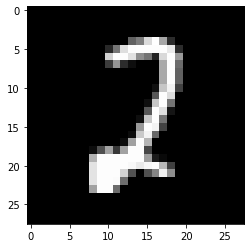

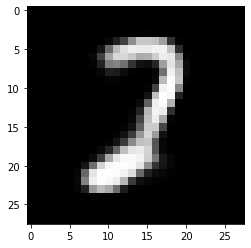

------------------------------
[epoch 061] average training loss: 100.6670
[epoch 062] average training loss: 100.5699
[epoch 063] average training loss: 100.5584
[epoch 064] average training loss: 100.4813
[epoch 065] average training loss: 100.4266
[epoch 065] average test loss: 101.8551


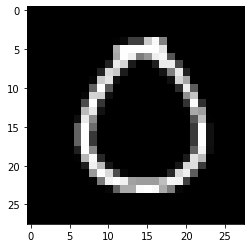

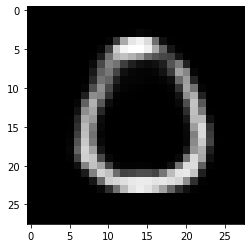

------------------------------


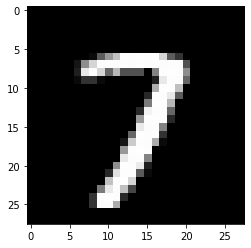

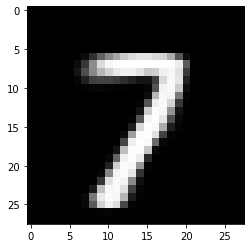

------------------------------


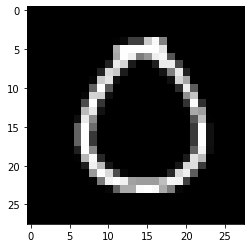

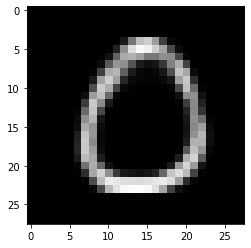

------------------------------
[epoch 066] average training loss: 100.3358
[epoch 067] average training loss: 100.3342
[epoch 068] average training loss: 100.2404
[epoch 069] average training loss: 100.1844
[epoch 070] average training loss: 100.1316
[epoch 070] average test loss: 101.6514


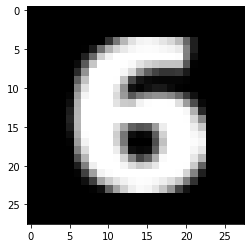

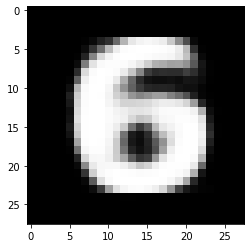

------------------------------


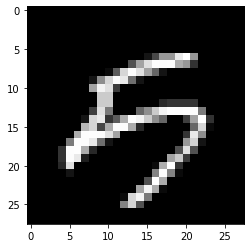

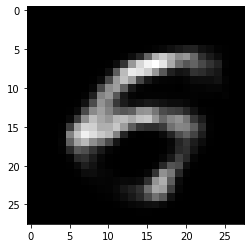

------------------------------


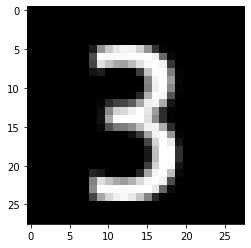

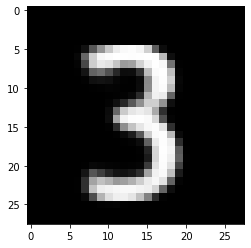

------------------------------
[epoch 071] average training loss: 100.0879
[epoch 072] average training loss: 100.0705
[epoch 073] average training loss: 99.9773
[epoch 074] average training loss: 99.9610
[epoch 075] average training loss: 99.8954
[epoch 075] average test loss: 101.4911


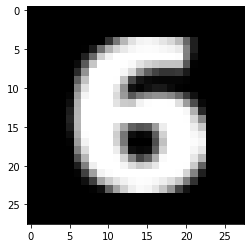

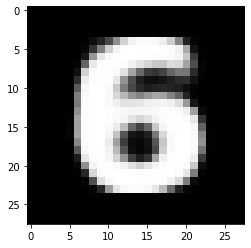

------------------------------


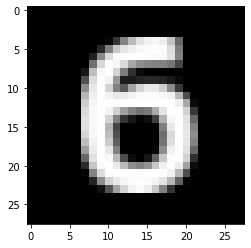

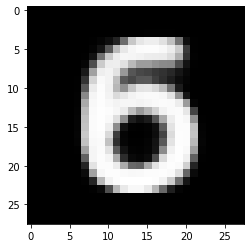

------------------------------


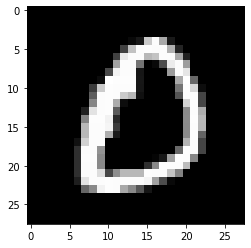

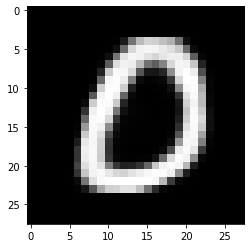

------------------------------
[epoch 076] average training loss: 99.8229
[epoch 077] average training loss: 99.8077
[epoch 078] average training loss: 99.7452
[epoch 079] average training loss: 99.6853
[epoch 080] average training loss: 99.6400
[epoch 080] average test loss: 101.2961


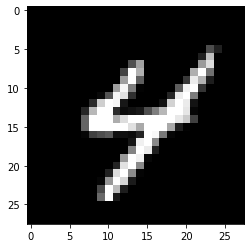

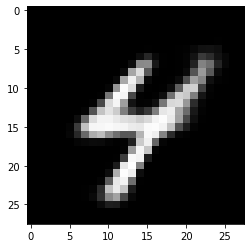

------------------------------


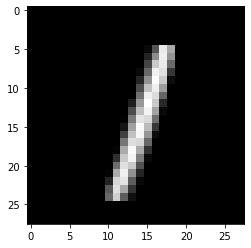

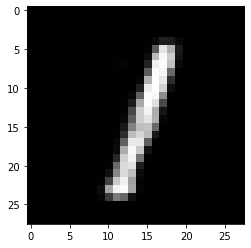

------------------------------


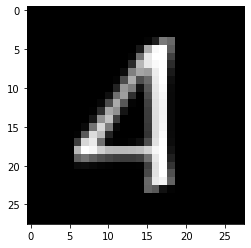

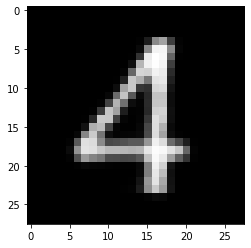

------------------------------
[epoch 081] average training loss: 99.6291
[epoch 082] average training loss: 99.5631
[epoch 083] average training loss: 99.5122
[epoch 084] average training loss: 99.4804
[epoch 085] average training loss: 99.4387
[epoch 085] average test loss: 101.2470


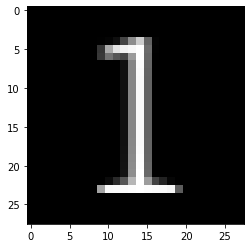

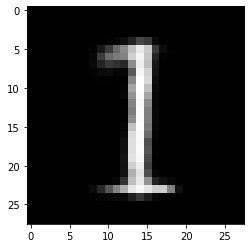

------------------------------


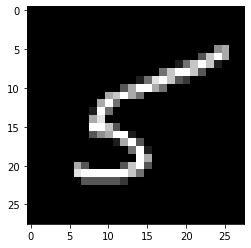

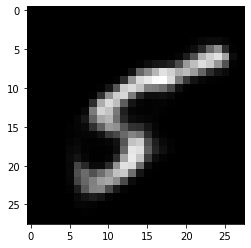

------------------------------


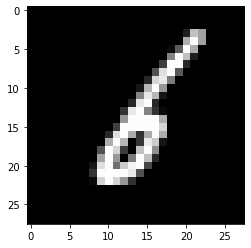

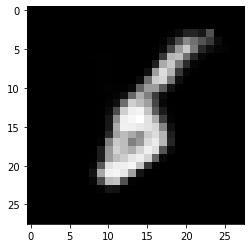

------------------------------
[epoch 086] average training loss: 99.4121
[epoch 087] average training loss: 99.3377
[epoch 088] average training loss: 99.3546
[epoch 089] average training loss: 99.2660
[epoch 090] average training loss: 99.2383
[epoch 090] average test loss: 100.9934


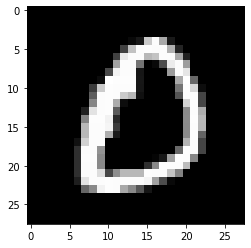

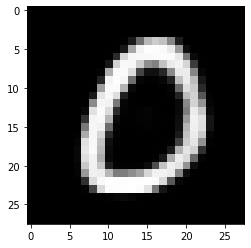

------------------------------


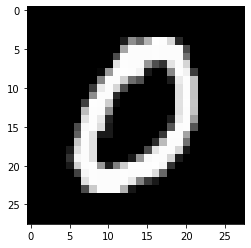

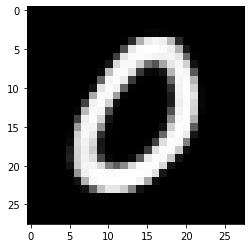

------------------------------


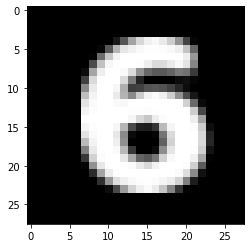

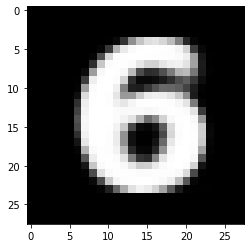

------------------------------
[epoch 091] average training loss: 99.1717
[epoch 092] average training loss: 99.1717
[epoch 093] average training loss: 99.1646
[epoch 094] average training loss: 99.0945
[epoch 095] average training loss: 99.0870
[epoch 095] average test loss: 100.9033


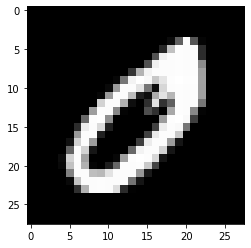

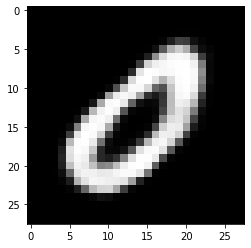

------------------------------


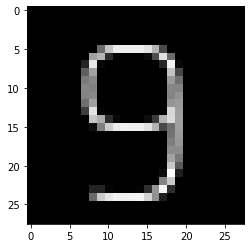

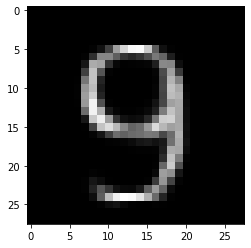

------------------------------


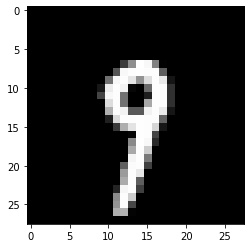

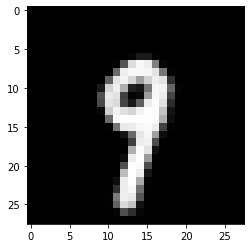

------------------------------
[epoch 096] average training loss: 99.0440
[epoch 097] average training loss: 98.9761
[epoch 098] average training loss: 98.9370
[epoch 099] average training loss: 98.9623


In [12]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d] average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))
        test_samples = random.choices(list(test_loader), k=3)
        for x_test, digit_test, is_handwritten_test in test_samples:
            x_shaped = x_test[0][0].reshape(1, 28*28)
            digit_shaped = torch.nn.functional.one_hot(digit_test[0], 10)[None, :]
            is_handwritten_shaped = torch.nn.functional.one_hot(is_handwritten_test[0], 2)[None, :]
            plot_regenerate(x_shaped, digit_shaped, is_handwritten_shaped)
            print("------------------------------")

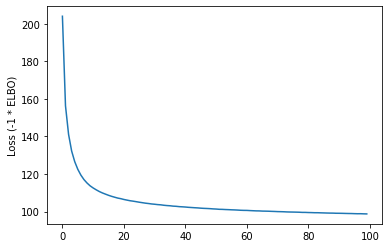

In [ ]:
plt.plot(range(len(train_elbo)), [-x for x in train_elbo])
plt.ylabel('Loss (-1 * ELBO)')
plt.show()

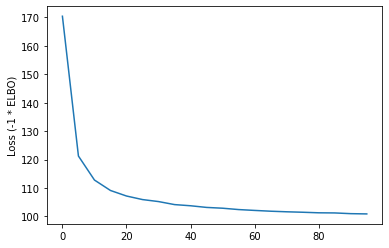

In [14]:
plt.plot([i * TEST_FREQUENCY for i in range(len(test_elbo))], [-x for x in test_elbo])
plt.ylabel('Loss (-1 * ELBO)')
plt.show()